In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
from glob import glob
from functools import partial
import tensorflow.keras as keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.python.keras.utils import conv_utils
import PIL
import PIL.Image
import gdown
from zipfile import ZipFile
import datetime
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [9]:
# params
num_epochs = 50# train for 400 epochs for good results
image_size = 512
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 640
padding = 0.25
dataset_name = "caltech_birds2011"

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.92
integration_steps = 1000

# architecture
noise_size = 512
depth = 7#64=4 128=5
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 32
learning_rate = 2e-5
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99
#num_epochs: 전체 데이터셋에 대한 반복 횟수(epoch)
#image_size: 생성할 이미지의 크기
#kid_image_size: Kernel Inception Distance(KID) 측정 시 사용할 이미지 해상도
#padding: 패딩 비율
#dataset_name: 사용할 데이터셋 이름
#max_translation: Adaptive Discriminator Augmentation(ADA)에서 사용될 최대 이동 비율
#max_rotation: ADA에서 사용될 최대 회전 비율
#max_zoom: ADA에서 사용될 최대 확대/축소 비율
#target_accuracy: ADA에서 목표로 하는 정확도
#integration_steps: ADA에서 사용될 적분 단계 수
#noise_size: 생성기 입력으로 사용될 노이즈 벡터의 크기
#depth: 생성기와 판별기에서 사용될 블록 수
#width: 블록 내부의 뉴런 수
#leaky_relu_slope: Leaky ReLU 함수에서 사용될 slope 값
#dropout_rate: 블록 내부에서 사용될 드롭아웃 비율
#batch_size: 미니배치 크기
#learning_rate: 학습률
#beta_1: Adam 옵티마이저의 decay rate beta_1
#ema: Exponential Moving Average(EMA)에 사용될 decay rate. 이 값이 높을수록 더 많은 이전 스텝의 정보를 반영합니다.

data

In [3]:

# 훈련용 마스크 답지  및 병변여부 
train_x_filenames = glob.glob('../data/d2/*.png')

train_x = np.zeros((len(train_x_filenames),image_size,image_size,3),dtype=np.int32)
autotune = tf.data.experimental.AUTOTUNE


buffer_size = image_size

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return img/255  ############


for (index, image) in enumerate(train_x_filenames[:]):
    
    img1=PIL.Image.open(image).convert("RGB")
    if(img1.size[0]>=img1.size[1]):
        ratio=image_size/img1.size[0]
    else:
        ratio=image_size/img1.size[1]
    width=ratio*img1.size[0]
    height=ratio*img1.size[1]
    height_padding_size=int((image_size-height)/2)
    width_padding_size=int((image_size-width)/2)
    img1=np.array(img1.resize((int(width),int(height))))
    train_x[index,height_padding_size:-height_padding_size,:] = img1
# 훈련용 마스크 답지  및 병변여부 
tf_train_x=tf.data.Dataset.from_tensor_slices(train_x)

tf_train_x=(tf_train_x.map(normalize_img, num_parallel_calls=autotune).cache()
    .batch(batch_size)).prefetch(tf.data.experimental.AUTOTUNE)



KID(Kernel Inception Distance)

In [10]:
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

Adaptive discriminator augmentation

In [11]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show (see figure 4), that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )

Network architecture

In [12]:
# DCGAN generator
def get_generator():
    noise_input = keras.Input(shape=(noise_size,))
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    for _ in range(depth - 1):
        x = layers.Conv2DTranspose(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 3))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)

    return keras.Model(image_input, output_score, name="discriminator")

GanModel

In [13]:
class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, training):
        latent_samples = tf.random.normal(shape=(batch_size, noise_size))
        # use ema_generator during inference
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=True
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=True,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True)

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, real_images):
        generated_images = self.generate(batch_size, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=25):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images, training=False)
            
            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()
        return generated_images


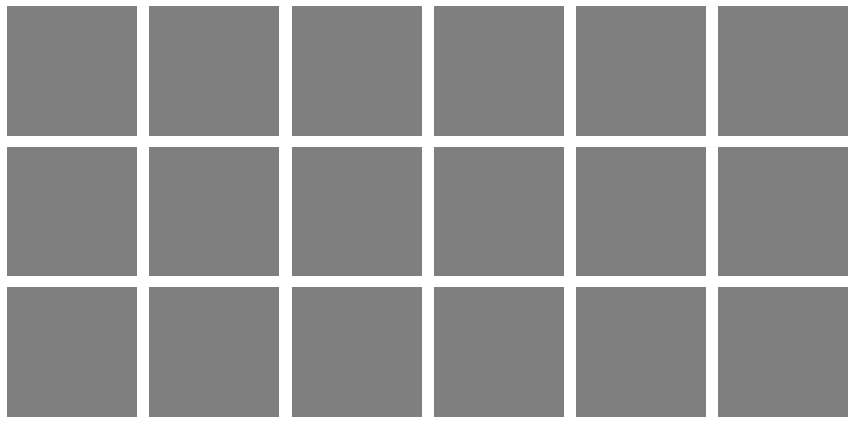

Epoch 1/50
54/54 [==============================] - 182s 3s/step - g_loss: 2.9840 - d_loss: 0.0992 - real_acc: 0.9913 - gen_acc: 0.9497 - aug_p: 0.0021
Epoch 2/50
54/54 [==============================] - 219s 4s/step - g_loss: 4.8735 - d_loss: 0.0704 - real_acc: 0.9925 - gen_acc: 0.9902 - aug_p: 0.0062
Epoch 3/50
54/54 [==============================] - 218s 4s/step - g_loss: 4.9648 - d_loss: 0.0300 - real_acc: 0.9931 - gen_acc: 0.9994 - aug_p: 0.0100
Epoch 4/50
54/54 [==============================] - 208s 4s/step - g_loss: 7.6025 - d_loss: 0.0126 - real_acc: 0.9977 - gen_acc: 0.9994 - aug_p: 0.0141
Epoch 5/50
34/54 [=================>............] - ETA: 1:16 - g_loss: 7.8804 - d_loss: 0.0078 - real_acc: 0.9982 - gen_acc: 1.0000 - aug_p: 0.0175

KeyboardInterrupt: 

In [14]:
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "../model/StyleGan/embryo_micro/model_{epoch:03d}.tf"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_kid",
    mode="min",
)

# run training and plot generated images periodically
for i in range(100):
    img=model.plot_images()
    cv2.imwrite("../data/d2/pred/ada_"+str(i)+".jpg",img[0].numpy()*255)
    model.fit(
    tf_train_x,
    epochs=num_epochs)
    model.save_weights("../model/StyleGan/embryo_micro/model512_"+str(i)+".tf")